# Project

In [56]:
from collections import Counter
# from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, balanced_accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import mord
from sklearn.tree import DecisionTreeClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols
# from statsmodels.graphics.regressionplots import plot_regress_exog

In [2]:
path = 'review-Alaska_10.json'

data_raw = pd.read_json(path, lines=True, encoding='utf-8')

invalid value encountered in cast


This indicates the presence of NA values in the data. However, as this is one of the aspects we intend to investigate, we will selectively perform data cleaning at a later stage.

In [3]:
print(data_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521515 entries, 0 to 521514
Data columns (total 8 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  521515 non-null  float64
 1   name     521515 non-null  object 
 2   time     521515 non-null  int64  
 3   rating   521515 non-null  int64  
 4   text     298257 non-null  object 
 5   pics     20851 non-null   object 
 6   resp     44232 non-null   object 
 7   gmap_id  521515 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 31.8+ MB
None


In [4]:
print(data_raw.head())

        user_id               name           time  rating  \
0  1.091298e+20         Nicki Gore  1566331951619       5   
1  1.132409e+20      Allen Ratliff  1504917982385       5   
2  1.130448e+20  Jonathan Tringali  1474765901185       4   
3  1.103292e+20             S Blad  1472858535682       4   
4  1.089896e+20     Daniel Formoso  1529649811341       5   

                                                text  pics  resp  \
0  We always stay here when in Valdez for silver ...  None  None   
1  Great campground for the price. Nice hot unlim...  None  None   
2  We tent camped here for 2 nights while explori...  None  None   
3  This place is just a few miles outside Valdez,...  None  None   
4  Probably the nicest and cleanest campground we...  None  None   

                                 gmap_id  
0  0x56b646ed2220b77f:0xd8975e316de80952  
1  0x56b646ed2220b77f:0xd8975e316de80952  
2  0x56b646ed2220b77f:0xd8975e316de80952  
3  0x56b646ed2220b77f:0xd8975e316de80952  
4  0x56b6

## Data Dictionary

- index: The index of the data.
- user_id: The ID of the reviewer.
- name: The name of the reviewer.
- time: The time of the review in Unix time format.
- rating: The rating given by the reviewer for the business.
- text: The text of the review.
- pics: Pictures associated with the review.
- resp: The business response to the review, including Unix time and the text of the response.
- gmap_id: The ID of the business.

Due to the nature of our research topic, which is to explore the influence of time of day on online ratings across different devices, we will be selecting specific data variables for further analysis. The data variables of interest include "time," "rating," and "pics." The reason for selecting "pics" is due to the unfortunate inability to obtain data directly related to device types in the comments. Therefore, we need to make a crucial assumption: 
**we assume that comments with pictures are uploaded using mobile devices, while comments without pictures are uploaded using non-mobile devices.**

## Data Preprocessing



In this section, we will perform data preprocessing, which includes data cleaning and data transformation. Data cleaning involves handling missing values, outliers, and inconsistencies in the dataset. Data transformation may involve converting the "pics" data into device type data, etc. These steps allow us to make use of the available information and derive meaningful insights from the dataset. 

In [35]:
# Label encoding and one-hot encoding
data_modified = (
    data_raw
    .assign(time=lambda x: pd.to_datetime(x['time'], unit='ms').dt.hour)
    # time[1,2,3] represents ['Morning', 'Noon', 'Evening']
    .assign(time=lambda x: pd.cut(x['time'], bins=[0, 8, 16, 24], labels=[1,2,3], right=False))
    # device[0,1] represents ['Non-mobile devices', 'Mobile devices']
    .assign(device=lambda x: x['pics'].notnull().astype(int))
    # rating[0,1] represents ['Rating not equal to 5', 'Rating equal to 5']
    # Convert rating to binary: 1 if rating is 5, else 0
    .assign(rating=lambda x: (x['rating'] == 5).astype(int))
    .filter(['time', 'rating', 'device'])
)


print(data_modified[:10])


  time  rating  device
0    3       1       0
1    1       1       0
2    1       0       0
3    3       0       0
4    1       1       0
5    2       1       0
6    1       1       1
7    1       0       0
8    1       0       0
9    3       0       0


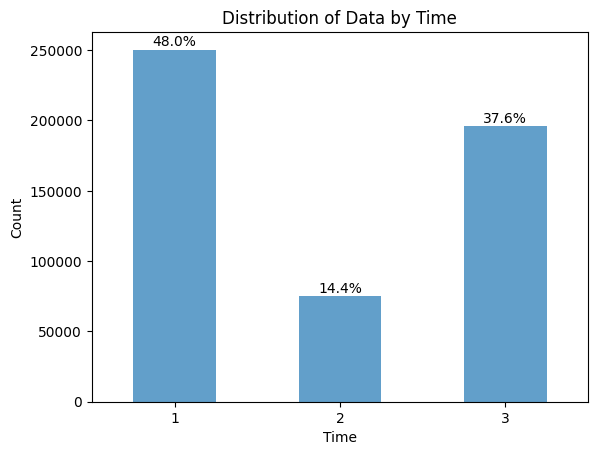

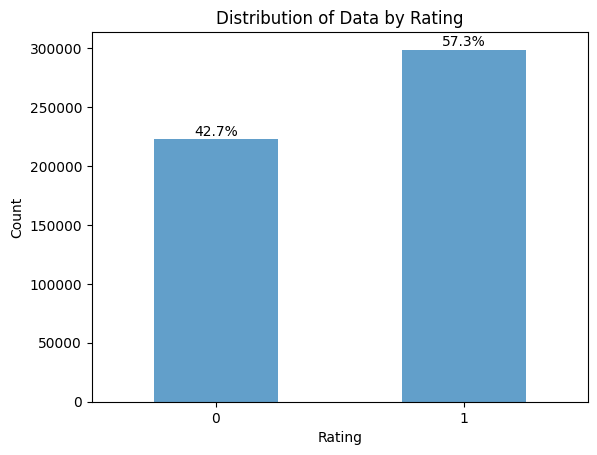

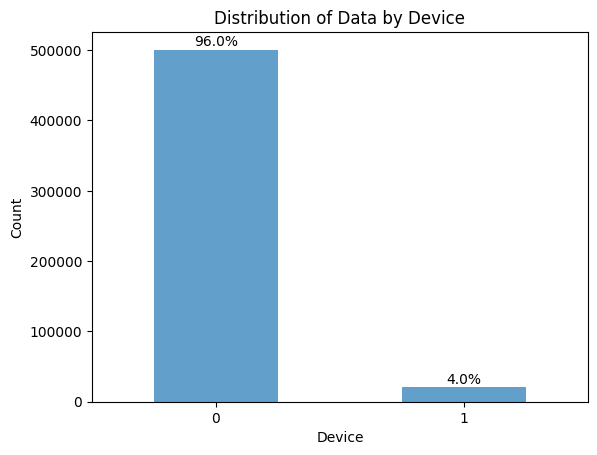

In [36]:
# Histogram for data distribution by time
counts = data_modified['time'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Distribution of Data by Time')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

# Histogram for data distribution by rating
counts = data_modified['rating'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Data by Rating')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

# Histogram for data distribution by devices
counts = data_modified['device'].value_counts().sort_index()
counts.plot(kind='bar', alpha=0.7)
plt.xlabel('Device')
plt.ylabel('Count')
plt.title('Distribution of Data by Device')
plt.xticks(rotation=0)  # Rotate x-axis labels

for i, v in enumerate(counts):
    plt.text(i, v + 0.01 * counts.max(), f'{v / counts.sum() * 100:.1f}%', ha='center')

plt.show()

In [37]:
print(data_modified.isnull().sum())

time      0
rating    0
device    0
dtype: int64


### Chi-square

In [38]:
# Chi-square test for 'time' and 'device'
chi2_time_device, p_time_device, dof_time_device, expected_time_device = stats.chi2_contingency(pd.crosstab(data_modified['time'], data_modified['device']))
print("Chi-square test result for 'time' and 'device':")
print("Chi-square statistic:", chi2_time_device)
print("P-value:", p_time_device)

Chi-square test result for 'time' and 'device':
Chi-square statistic: 77.89168097553406
P-value: 1.2190917242198965e-17


In [39]:
# Chi-square test for 'rating' and 'device'
chi2_rating_device, p_rating_device, dof_rating_device, expected_rating_device = stats.chi2_contingency(pd.crosstab(data_modified['rating'], data_modified['device']))
print("\nChi-square test result for 'rating' and 'device':")
print("Chi-square statistic:", chi2_rating_device)
print("P-value:", p_rating_device)


Chi-square test result for 'rating' and 'device':
Chi-square statistic: 2417.7236387438347
P-value: 0.0


In [40]:
# Chi-square test for 'rating' and 'time'
chi2_rating_time, p_rating_time, dof_rating_time, expected_rating_time = stats.chi2_contingency(pd.crosstab(data_modified['rating'], data_modified['time']))
print("\nChi-square test result for 'rating' and 'time':")
print("Chi-square statistic:", chi2_rating_time)
print("P-value:", p_rating_time)


Chi-square test result for 'rating' and 'time':
Chi-square statistic: 342.31263700319306
P-value: 4.653238705461872e-75


The results of the chi-square test indicate that there is some degree of correlation between all three variables.

### Correlation Matrix

In [41]:
data_modified['time'] = data_modified['time'].astype(int)
corr_matrix = data_modified.corr()

print(corr_matrix)


            time    rating    device
time    1.000000  0.008606  0.002651
rating  0.008606  1.000000  0.068098
device  0.002651  0.068098  1.000000


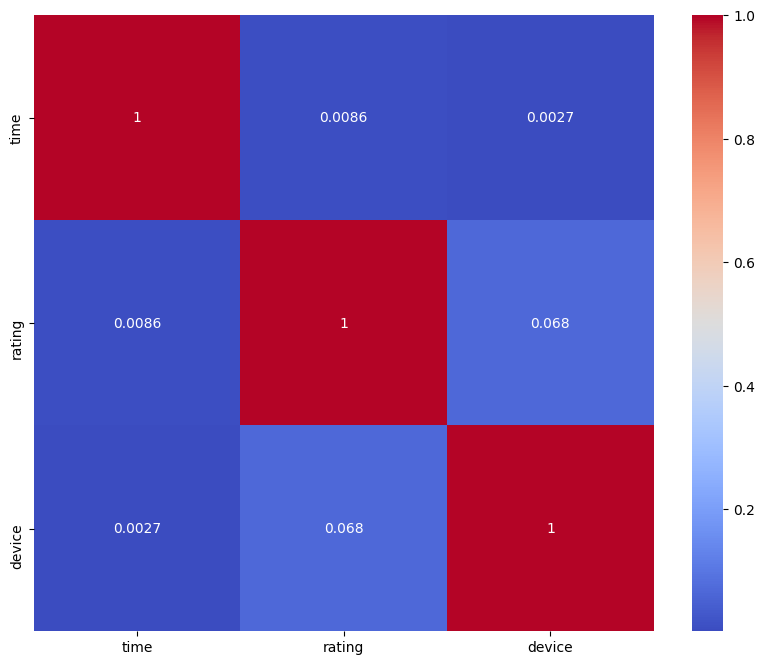

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()


### Multicollinearity test

In [43]:
X = data_modified[['time', 'rating', 'device']]
vif_data = pd.DataFrame()
vif_data['Features'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nMulticollinearity test:")
print(vif_data)


Multicollinearity test:
  Features       VIF
0     time  1.884508
1   rating  1.894729
2   device  1.044160


The Variance Inflation Factors (VIF) for the 'time', 'rating', and 'device' variables are 4.27, 4.32, and 1.05 respectively. Typically, a VIF value greater than 5 or 10 indicates high multicollinearity. Here, none of the VIF values exceed these thresholds, suggesting that multicollinearity is not a significant concern in this dataset.

Summary: In the data processing phase of this project, we first cleaned and transformed the data appropriately. We then performed exploratory data analysis to visualize the distribution of ratings across different times of day and devices. Next, we conducted chi-square tests which revealed significant associations between 'time', 'device', and 'rating'. Correlation Matrix then proved these associations are not linear. A Variance Inflation Factor (VIF) test confirmed that multicollinearity was not a significant concern. This prepared the data effectively for the subsequent modeling phase.

## Modeling

### Train and Test Sets

In [44]:
# Separate features (X) and target variable (y) in the balanced dataset
X = data_modified.drop('rating', axis=1)
y = data_modified['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2221877)


### Data Balancing

It can be seen that there is a significant data imbalance between the different ratings. Having tried sampling and undersampling, I ended up combining them to try and get the most optimal sampling results to support my models.

In [45]:
# Calculate the number of samples in each class
counter = Counter(y)

# Define the target sample numbers for over-sampling and under-sampling
max_samples = max(counter.values())
min_samples = min(counter.values())

# Define pipeline
over = SMOTE(sampling_strategy={class_label: max_samples for class_label in counter})
under = RandomUnderSampler(sampling_strategy={class_label: min_samples for class_label in counter})
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Apply the pipeline
X_resampled, y_resampled = pipeline.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


Sample numbers before resampling: Counter({1: 298638, 0: 222877})
Sample numbers after resampling: Counter({0: 222877, 1: 222877})


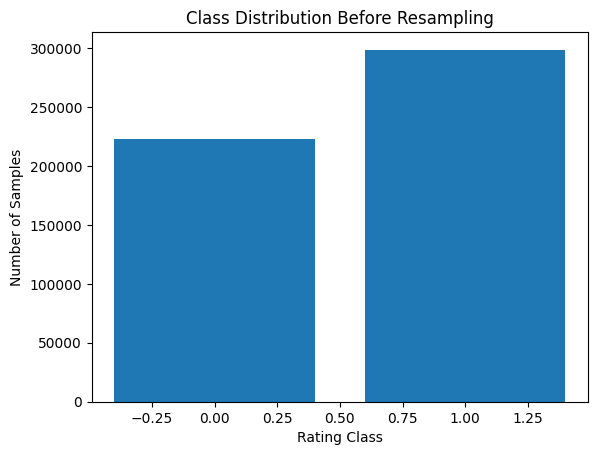

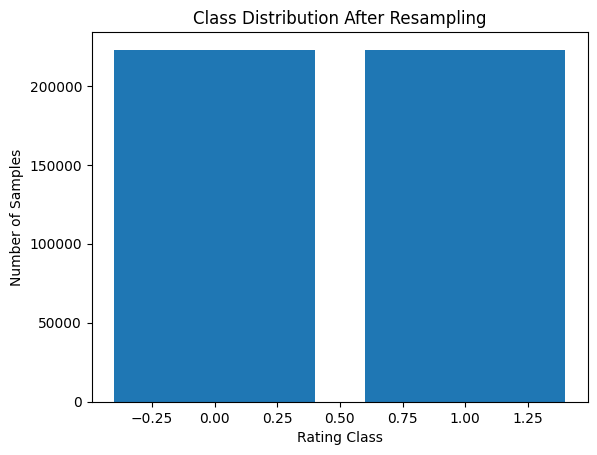

In [46]:
# Calculate the number of samples in each class before resampling
print("Sample numbers before resampling:", counter)

# Calculate the number of samples in each class after resampling
counter_after = Counter(y_resampled)
print("Sample numbers after resampling:", counter_after)

# Visualize class distribution before resampling
plt.bar(counter.keys(), counter.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before Resampling')
plt.show()

# Visualize class distribution after resampling
plt.bar(counter_after.keys(), counter_after.values())
plt.xlabel('Rating Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution After Resampling')
plt.show()


In [47]:
# Description of 'time' for each 'rating'
print(data_modified.groupby('rating')['time'].describe())

# Description of 'device' for each 'rating'
print(data_modified.groupby('rating')['device'].describe())


           count      mean       std  min  25%  50%  75%  max
rating                                                       
0       222877.0  1.887005  0.913088  1.0  1.0  2.0  3.0  3.0
1       298638.0  1.903000  0.924071  1.0  1.0  2.0  3.0  3.0
           count      mean       std  min  25%  50%  75%  max
rating                                                       
0       222877.0  0.024538  0.154713  0.0  0.0  0.0  0.0  1.0
1       298638.0  0.051507  0.221030  0.0  0.0  0.0  0.0  1.0


In [18]:
# # # Separate features (X) and target variable (y)
# # X = data_modified.drop('rating', axis=1)
# # y = data_modified['rating']

# # Apply SMOTEENN using training sets
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# # # Create a new balanced dataframe
# # balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
# # balanced_data['rating'] = y_resampled

# # # Check the balanced distribution of ratings
# # print(balanced_data['rating'].value_counts())

# # Check the balanced distribution of ratings
# print(pd.Series(y_resampled).value_counts())


In [19]:
# from imblearn.combine import SMOTETomek

# # Separate features (X) and target variable (y)
# X = data_modified.drop('rating', axis=1)
# y = data_modified['rating']

# # Apply SMOTETomek
# smote_tomek = SMOTETomek(random_state=42)
# X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# # Create a new balanced dataframe
# balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
# balanced_data['rating'] = y_resampled

# # Check the balanced distribution of ratings
# print(balanced_data['rating'].value_counts())


### Decision Tree

Accuracy score:  0.5141948477009263
              precision    recall  f1-score   support

           0       0.51      0.62      0.56     44546
           1       0.52      0.41      0.46     44605

    accuracy                           0.51     89151
   macro avg       0.51      0.51      0.51     89151
weighted avg       0.51      0.51      0.51     89151



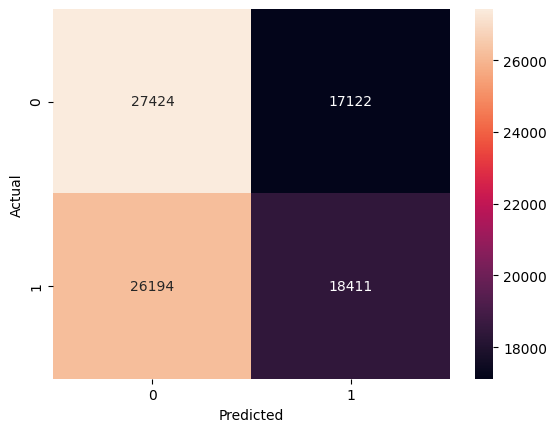

In [48]:
model_DT = DecisionTreeClassifier()

model_DT.fit(X_resampled, y_resampled)

predictions_DT = model_DT.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_DT))
print(classification_report(y_test, predictions_DT))

cm = confusion_matrix(y_test, predictions_DT)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

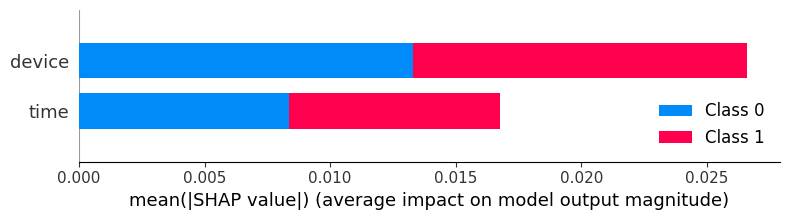

In [49]:
# Create an Explainer object
explainer_DT = shap.Explainer(model_DT)

# Calculate SHAP values
shap_values_DT = explainer_DT.shap_values(X_test)

# Visualise the first prediction's explanation
shap.summary_plot(shap_values_DT, X_test)

In [50]:
# Calculate the mean SHAP values for each feature
mean_shap_values_DT = np.mean(shap_values_DT, axis=0)

# Convert the mean SHAP values into a DataFrame with feature names
mean_shap_df_DT = pd.DataFrame(mean_shap_values_DT, columns=X_test.columns)

# Display the mean SHAP values
print(mean_shap_df_DT)

               time        device
0      1.409463e-17  1.040834e-17
1      6.938894e-18 -2.775558e-17
2      1.409463e-17  1.040834e-17
3     -1.040834e-17  1.170938e-17
4      1.409463e-17  1.040834e-17
...             ...           ...
89146 -4.076600e-17  1.127570e-17
89147 -1.040834e-17  1.170938e-17
89148  1.409463e-17  1.040834e-17
89149  1.409463e-17  1.040834e-17
89150 -4.076600e-17  1.127570e-17

[89151 rows x 2 columns]


### Random Forest

Accuracy score:  0.5141948477009263
              precision    recall  f1-score   support

           0       0.51      0.62      0.56     44546
           1       0.52      0.41      0.46     44605

    accuracy                           0.51     89151
   macro avg       0.51      0.51      0.51     89151
weighted avg       0.51      0.51      0.51     89151



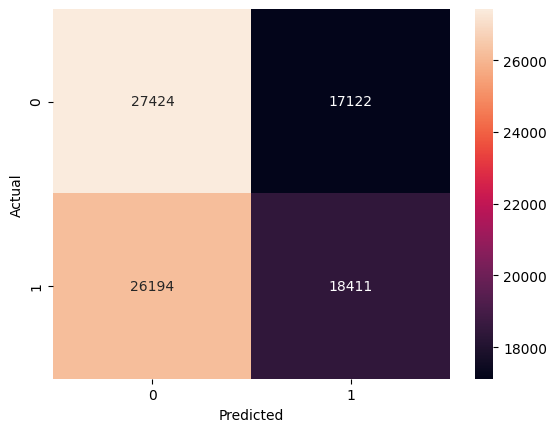

In [51]:
model_RF = RandomForestClassifier()

model_RF.fit(X_resampled, y_resampled)

predictions_RF = model_RF.predict(X_test)

print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_RF))
print(classification_report(y_test, predictions_RF))

cm = confusion_matrix(y_test, predictions_RF)
sns.heatmap(cm, annot=True, fmt=".0f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Ordinal Logistic Regression

Accuracy score:  0.5133791912148156
              precision    recall  f1-score   support

           0       0.51      0.98      0.67     44546
           1       0.68      0.05      0.10     44605

    accuracy                           0.51     89151
   macro avg       0.59      0.51      0.38     89151
weighted avg       0.59      0.51      0.38     89151



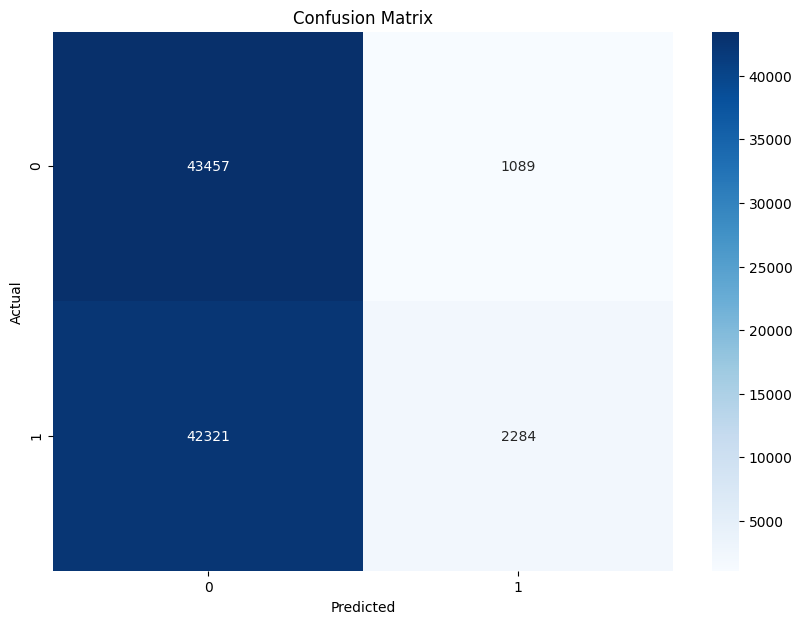

In [52]:
# Create an instance of the LogisticAT model
model_OL = mord.LogisticAT()

# Fit the model to the data
model_OL.fit(X_resampled, y_resampled)

# Use the model to make predictions
predictions_OL = model_OL.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_OL))
print(classification_report(y_test, predictions_OL))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions_OL)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Gradient Boosting 

Accuracy score:  0.5141948477009263
              precision    recall  f1-score   support

           0       0.51      0.62      0.56     44546
           1       0.52      0.41      0.46     44605

    accuracy                           0.51     89151
   macro avg       0.51      0.51      0.51     89151
weighted avg       0.51      0.51      0.51     89151



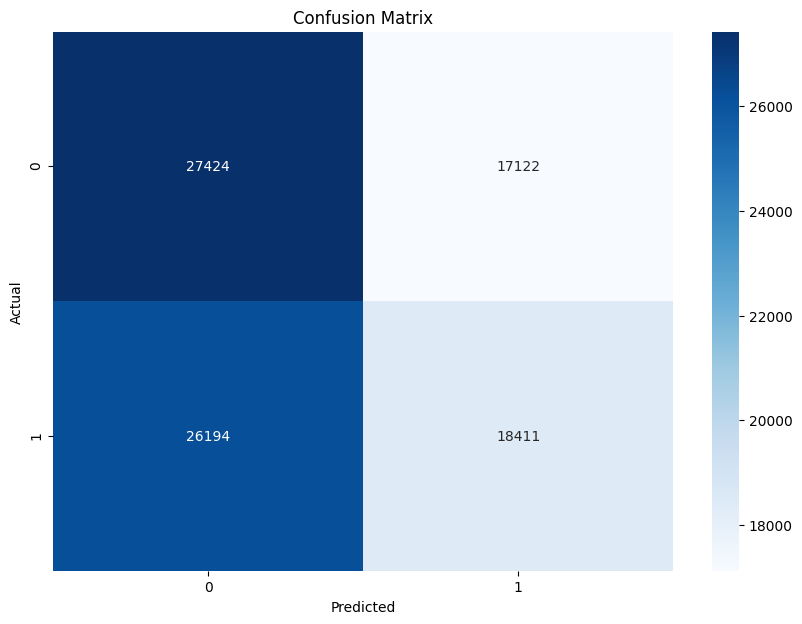

In [53]:
# Create a GradientBoostingClassifier
model_GB = GradientBoostingClassifier()

model_GB.fit(X_resampled, y_resampled)

predictions_GB = model_GB.predict(X_test)

# Evaluate the model's performance
print('Accuracy score: ', balanced_accuracy_score(y_test, predictions_GB))
print(classification_report(y_test, predictions_GB))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions_GB)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt=".0f", cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### Model Comparisons


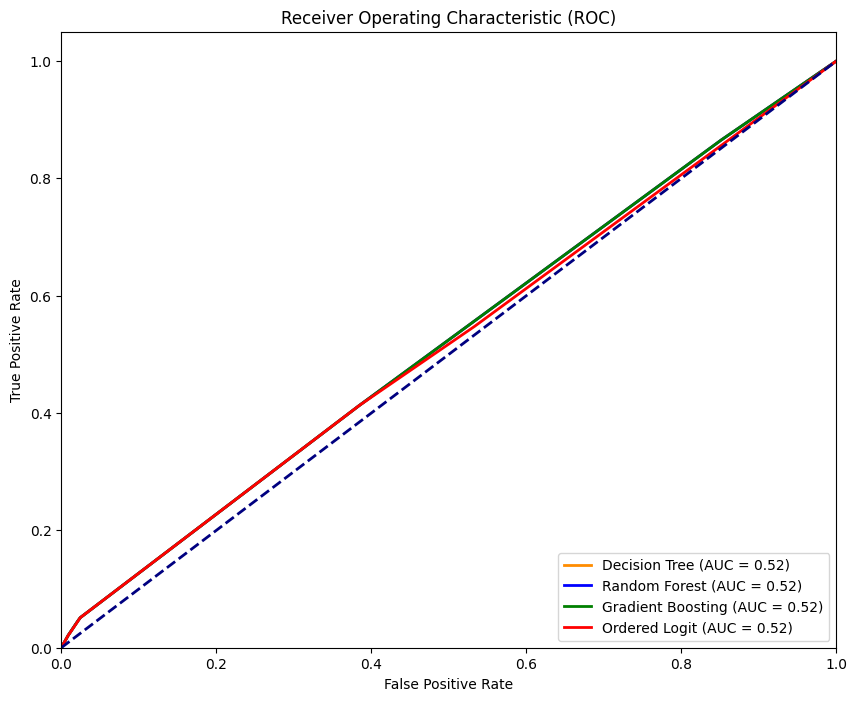

Decision Tree AUC: 0.5211815635283019
Random Forest AUC: 0.5211815635283019
Gradient Boosting AUC: 0.5211815635283019
Ordered Logit AUC: 0.5168580381207039


In [58]:
# Predict probabilities for all models
probs_DT = model_DT.predict_proba(X_test)[:, 1]
probs_RF = model_RF.predict_proba(X_test)[:, 1]
probs_GB = model_GB.predict_proba(X_test)[:, 1]
probs_OL = model_OL.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_DT, tpr_DT, _ = roc_curve(y_test, probs_DT)
roc_auc_DT = auc(fpr_DT, tpr_DT)

fpr_RF, tpr_RF, _ = roc_curve(y_test, probs_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

fpr_GB, tpr_GB, _ = roc_curve(y_test, probs_GB)
roc_auc_GB = auc(fpr_GB, tpr_GB)

fpr_OL, tpr_OL, _ = roc_curve(y_test, probs_OL)
roc_auc_OL = auc(fpr_OL, tpr_OL)

# Plot ROC curves in the same plot
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_DT, tpr_DT, color='darkorange', lw=lw, label=f'Decision Tree (AUC = {roc_auc_DT:0.2f})')
plt.plot(fpr_RF, tpr_RF, color='blue', lw=lw, label=f'Random Forest (AUC = {roc_auc_RF:0.2f})')
plt.plot(fpr_GB, tpr_GB, color='green', lw=lw, label=f'Gradient Boosting (AUC = {roc_auc_GB:0.2f})')
plt.plot(fpr_OL, tpr_OL, color='red', lw=lw, label=f'Ordered Logit (AUC = {roc_auc_OL:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Optional: Print out AUC scores
print("Decision Tree AUC:", roc_auc_score(y_test, probs_DT))
print("Random Forest AUC:", roc_auc_score(y_test, probs_RF))
print("Gradient Boosting AUC:", roc_auc_score(y_test, probs_GB))
print("Ordered Logit AUC:", roc_auc_score(y_test, probs_OL))


In [62]:
def bootstrap_auc(y, probs, n_iterations=1000):
    """ Calculate bootstrap AUC scores. """
    auc_scores = []
    y = y.to_numpy()  # Convert to numpy array
    for _ in range(n_iterations):
        # Bootstrapped indices
        indices = resample(np.arange(len(y)))
        if len(np.unique(y[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            continue
        auc_score = roc_auc_score(y[indices], probs[indices])
        auc_scores.append(auc_score)
    return auc_scores

# Get bootstrapped AUC scores
auc_scores_DT = bootstrap_auc(y_test, probs_DT)
auc_scores_RF = bootstrap_auc(y_test, probs_RF)
auc_scores_GB = bootstrap_auc(y_test, probs_GB)
auc_scores_OL = bootstrap_auc(y_test, probs_OL)

# Calculate 95% CI for AUC
conf_int_DT = np.percentile(auc_scores_DT, [2.5, 97.5])
conf_int_RF = np.percentile(auc_scores_RF, [2.5, 97.5])
conf_int_GB = np.percentile(auc_scores_GB, [2.5, 97.5])
conf_int_OL = np.percentile(auc_scores_OL, [2.5, 97.5])

print(f"Decision Tree AUC: {np.mean(auc_scores_DT):.4f} (95% CI: {conf_int_DT[0]:.4f}, {conf_int_DT[1]:.4f})")
print(f"Random Forest AUC: {np.mean(auc_scores_RF):.4f} (95% CI: {conf_int_RF[0]:.4f}, {conf_int_RF[1]:.4f})")
print(f"Gradient Boosting AUC: {np.mean(auc_scores_GB):.4f} (95% CI: {conf_int_GB[0]:.4f}, {conf_int_GB[1]:.4f})")
print(f"Ordered Logit AUC: {np.mean(auc_scores_OL):.4f} (95% CI: {conf_int_OL[0]:.4f}, {conf_int_OL[1]:.4f})")


Decision Tree AUC: 0.5212 (95% CI: 0.5177, 0.5248)
Random Forest AUC: 0.5211 (95% CI: 0.5175, 0.5246)
Gradient Boosting AUC: 0.5212 (95% CI: 0.5177, 0.5245)
Ordered Logit AUC: 0.5167 (95% CI: 0.5131, 0.5203)
